## Data

In [1]:
import matplotlib
import nltk
import pandas as pd

from config import BASE_DIR

RERUN = True
matplotlib.rcParams['figure.figsize'] = (15, 10)


**Conditions**
1. Books greater then 300 words.
2. Hebrew books.
3. Each book divided into 100 words chunks.

So we have 202 scrolls that match our criteria (with 39 compositions).
Only 129 scrolls have composition label.

In [2]:
DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_100_words_nonbib_17_06_2024.csv"
df = pd.read_csv(DATA_PATH)
df_grouped = df.groupby("book")["text"].apply(' '.join).reset_index()
book_info = df[["book", "composition", "section"]].drop_duplicates()
df_by_book = pd.merge(df_grouped, book_info, on="book", how="inner")
df_by_book["number_of_words"] = df_by_book['text'].str.split().map(lambda x: len(x))

df


book      sentence_path  \
0        CD        CD:1:1-1:12   
1        CD        CD:1:12-2:1   
2        CD        CD:2:1-2:10   
3        CD       CD:2:10-2:20   
4        CD        CD:2:20-3:8   
...     ...                ...   
1503  11Q20   11Q20:14:8-14:17   
1504  11Q20  11Q20:14:17-14:26   
1505  11Q20   11Q20:14:26-15:6   
1506  11Q20    11Q20:15:6-16:6   
1507  11Q20   11Q20:16:6-f42:1   

                                               text_lex  \
0     שמע כל ידע צדק בין מעשה אל ריב ל כל בשר משפט ע...   
1     אחרון עשה דור אחרון עדה בגד הם סור דרך היא עת ...   
2     כל המון מעשה נדה פנה שמע אל כל בוא ברית גלה אז...   
3     כל שנה עולם כל קום ל קריא שם יתר פליטה ארץ מלא...   
4     בשר היה חרבה גוע היה היה עשה רצון שמר מצוה עשה...   
...                                                 ...   
1503  נגע פנה שדה עצם אדם מות חלל חרב מות דם אדם מות...   
1504  כל שרץ ארץ טמא חלד עכבר צב מין לטאה כח חמט תנש...   
1505  נשא עצם נבלה עור בשר צפרן כבס בגד רחץ מים בוא ...   
1506  חיה בוא ירש ארץ אנכי נתן ל ירש כל יום איש לקח ...   
1507  עם אחרון סקל אבן מות בקש נדח נחשת טפח על ש תלב...   

                                                   text  n_words_lex  n_words  \
0     ועתה שמעו כל יודעי צדק ובינו במעשי אל כי ריב ל...           82       92   
1     אחרונים את אשר עשה בדור אחרון בעדת בוגדים הם ס...           85       96   
2     את כל המונם ומעשיהם לנדה לפניו ועתה שמעו אלי כ...           79       94   
3     לכל שני עולם ובכולם הקים לו קריאי שם למען התיר...           79       94   
4     בשר אשר היה בחרבה כי גוע ויהיו כלא היו בעשותם ...           81       95   
...                                                 ...          ...      ...   
1503  יגע על פני השדה בעצם אדם מת ובחלל חרב או במת א...           78       92   
1504  כול שרץ הארץ תטמאו החולד והעכבר והצב למינו והל...           73       91   
1505  הנושא מעצמותמה ומנבלתמה עור ובשר וצפורן וכבס ב...           80       95   
1506  תחיה ובאתה וירשתה את הארץ אשר אנוכי נותן לכמה ...           73       95   
1507  העם באחרונה וסקלתו באבנים ומת כי בקש להדיחכה נ...           37       42   

      construct to absolute nouns ratio  \
0                              0.666667   
1                              0.545455   
2                              0.481481   
3                              1.250000   
4                              1.100000   
...                                 ...   
1503                           0.478261   
1504                           0.416667   
1505                           0.375000   
1506                           0.666667   
1507                           0.300000   

      construct nouns and adjectives percentage  noun to verb ratio  \
0                                      0.110092            2.250000   
1                                      0.114286            1.241379   
2                                      0.130841            2.222222   
3                                      0.205607            1.714286   
4                                      0.103774            1.000000   
...                                         ...                 ...   
1503                                   0.113208            1.545455   
1504                                   0.093458            1.700000   
1505                                   0.084906            1.333333   
1506                                   0.076923            1.052632   
1507                                   0.026786            4.666667   

      definite_article_percentage  ...  aCr percentage  oM percentage  \
0                        0.917431  ...             0.0            0.0   
1                        4.761905  ...             0.0            0.0   
2                        0.934579  ...             0.0            0.0   
3                        0.934579  ...             0.0            0.0   
4                        1.886792  ...             0.0            0.0   
...                           ...  ...             ...            ...   
1503                    12.264151  

## Most correlated scrolls

### Similarity between scrolls

In [3]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import Levenshtein
import numpy as np
from scipy.stats import spearmanr
from transformers import AutoTokenizer, AutoModel
import torch


def plot_heatmap(similarity_df, vectorizer_type, similarity_metric):
    similarity_sums = similarity_df.sum(axis=1)
    sorted_books = similarity_sums.sort_values(ascending=True).index

    sorted_similarity_df = similarity_df.loc[sorted_books, sorted_books]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_similarity_df, cmap='coolwarm', linewidths=.5, annot=False)
    plt.title(
        'Sorted Book Similarity Heatmap (vectorizer: {}, similarity: {})'.format(vectorizer_type, similarity_metric))
    plt.show()


def compute_similarity(df, text_column='text', book_column='book', vectorizer_type='tfidf', similarity_metric='cosine',
                       to_plot=False, normalize=True):
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(df[text_column])
    elif vectorizer_type == 'trigram':
        vectorizer = CountVectorizer(ngram_range=(3, 3), analyzer='char')
        tfidf_matrix = vectorizer.fit_transform(df[text_column])
    elif vectorizer_type == 'BOW':
        vectorizer = CountVectorizer(analyzer='word')
        tfidf_matrix = vectorizer.fit_transform(df[text_column])
    elif vectorizer_type == 'bert':
        tokenizer = AutoTokenizer.from_pretrained('onlplab/alephbert-base')
        model = AutoModel.from_pretrained('onlplab/alephbert-base')

        def bert_embed(texts):
            inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            return embeddings.cpu().numpy()

        tfidf_matrix = bert_embed(df[text_column].tolist())
    else:
        raise ValueError("Unsupported vectorizer type.")

    # Calculate similarity matrix
    if similarity_metric == 'cosine':
        similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    elif similarity_metric == 'euclidean':
        similarity_matrix = euclidean_distances(tfidf_matrix, tfidf_matrix)
        similarity_matrix = np.max(similarity_matrix) - similarity_matrix  # Convert to similarity
    elif similarity_metric == 'levenshtein':
        n = len(df)
        similarity_matrix = np.zeros((n, n))
        for i in tqdm(range(n), desc="levenshtein"):
            for j in range(n):
                if i != j:
                    similarity_matrix[i, j] = Levenshtein.distance(df.iloc[i][text_column], df.iloc[j][text_column])
        similarity_matrix = np.max(similarity_matrix) - similarity_matrix
    elif similarity_metric == 'spearman':
        tfidf_array = tfidf_matrix.toarray() if vectorizer_type != 'bert' else tfidf_matrix
        n = len(df)
        similarity_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    corr, _ = spearmanr(tfidf_array[i], tfidf_array[j])
                    similarity_matrix[i, j] = corr
    else:
        raise ValueError("Unsupported similarity metric. Use 'cosine', 'euclidean', 'levenshtein', or 'spearman'.")

    if normalize:
        np.fill_diagonal(similarity_matrix, 0)

        # Normalize the similarity matrix
        if similarity_metric in ['cosine', 'spearman']:
            similarity_matrix = similarity_matrix  # These metrics are already between -1 and 1
        else:
            similarity_matrix = (similarity_matrix - np.mean(
                similarity_matrix[similarity_matrix != 0])) / np.std(similarity_matrix[similarity_matrix != 0])

    # Create a DataFrame for the similarity matrix
    similarity_df = pd.DataFrame(similarity_matrix, index=df[book_column], columns=df[book_column])

    if to_plot:
        plot_heatmap(similarity_df, vectorizer_type, similarity_metric)

    return similarity_df


def save_similarity_matrices(df, vectorizer_types: list, similarity_metrics: list, text_column='text',
                             book_column='book', normalize=True):
    similarity_matrices = {}

    for vectorizer in tqdm(vectorizer_types, desc="Vectorizers"):
        for metric in tqdm(similarity_metrics, desc="Metrics", leave=False):
            similarity_df = compute_similarity(df, text_column, book_column, vectorizer, metric, normalize=normalize)
            similarity_matrices[f'{vectorizer}_{metric}'] = similarity_df

    return similarity_matrices


def analyze_matrices(similarity_matrices):
    matrix_values = np.array([matrix.values for matrix in similarity_matrices.values()])
    mean_matrix = np.mean(matrix_values, axis=0)
    std_matrix = np.std(matrix_values, axis=0)

    sample_matrix = list(similarity_matrices.values())[0]
    mean_df = pd.DataFrame(mean_matrix, index=sample_matrix.index, columns=sample_matrix.columns)
    std_df = pd.DataFrame(std_matrix, index=sample_matrix.index, columns=sample_matrix.columns)

    significant_correlations = []
    for i in range(mean_df.shape[0]):
        for j in range(i + 1, mean_df.shape[1]):
            mean_value = mean_df.iloc[i, j]
            std_value = std_df.iloc[i, j]
            z_value = mean_value / std_value if std_value != 0 else 0
            p_value = 1 - np.abs(z_value)
            significant_correlations.append(
                (mean_df.index[i], mean_df.columns[j], mean_value, std_value, z_value, p_value))

    return mean_df, std_df, significant_correlations


def plot_heatmap(similarity_df, vectorizer_type, similarity_metric, top_n=30, title=None):
    similarity_sums = similarity_df.sum(axis=1)
    sorted_books = similarity_sums.sort_values(ascending=False).index

    sorted_similarity_df = similarity_df.loc[sorted_books, sorted_books].iloc[:top_n, :top_n]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_similarity_df, cmap='coolwarm', linewidths=.5, annot=False)
    if title:
        plt.title(
            'Sorted Book Similarity Heatmap (vectorizer: {}, similarity: {}). {}'.format(vectorizer_type,
                                                                                         similarity_metric, title))
    else:
        plt.title(
            'Sorted Book Similarity Heatmap (vectorizer: {}, similarity: {})'.format(vectorizer_type,
                                                                                     similarity_metric))
    plt.show()


def get_top_pairs_by_method(similarity_matrices, method):
    df = similarity_matrices[method]

    stacked_df = df.stack()
    stacked_df = stacked_df.to_frame().rename(columns={0: "sim"})
    stacked_df = stacked_df[stacked_df.index.get_level_values(0) != stacked_df.index.get_level_values(1)].sort_values(
        by="sim", ascending=False)
    pairs = stacked_df.to_dict(orient="dict").get("sim")
    pairs = {tuple(frozenset(key)): value for key, value in pairs.items()}
    return pairs


def average_similarities(similarity_matrices_all):
    # Collect all pairs and their similarities from all methods
    combined_similarities = {}
    for method, matrix in similarity_matrices_all.items():
        pairs = get_top_pairs_by_method(similarity_matrices_all, method)
        for pair, sim in pairs.items():
            if pair not in combined_similarities:
                combined_similarities[pair] = []
            combined_similarities[pair].append(sim)

    # Calculate the average similarity for each pair
    averaged_similarities = {pair: sum(sims) / len(sims) for pair, sims in combined_similarities.items()}

    return averaged_similarities


def get_best_pairs(similarity_matrices_all, n_pairs, method=None):
    if method:
        pairs = get_top_pairs_by_method(similarity_matrices_all, method=method)
        pairs = sorted(pairs.items(), key=lambda x: x[1], reverse=True)
        return pairs[:n_pairs]
    else:
        averaged_similarities = average_similarities(similarity_matrices_all)
        sorted_pairs = sorted(averaged_similarities.items(), key=lambda x: x[1], reverse=True)
        return sorted_pairs[:n_pairs]

# TODO need to do it robust across all scrolls. That means, using CV for testing similiarities.
# vectorizer_types = ['tfidf', 'trigram', "BOW"
#                     # 'bert'
#                     ]
# similarity_metrics = ['cosine',
#                       # 'euclidean', 'levenshtein', 
#                       # 'spearman'
#                       ]


# similarity_matrices = save_similarity_matrices(df_by_book.sort_values(by="number_of_words", ascending=False).head(20),
#                                                vectorizer_types, similarity_metrics, text_column='text',
#                                                book_column='book', normalize=False)
# mean_df, std_df, significant_correlations = analyze_matrices(similarity_matrices)

# corr_stats = pd.DataFrame(significant_correlations, columns=["book1", "book2", "mean", "std_", "z_value", "p_value"])
# most_correlated_books = corr_stats[
#     (np.abs(corr_stats["p_value"]) <= 0.2) & (corr_stats["mean"] >= corr_stats["mean"].quantile(0.5))].sort_values(
#     by="mean", ascending=False)
# most_correlated_books


This code is taking a list of vectorizers, a list of similarity metrics, for each one compute the corresponding similiarity matrix and normalize the results. Than im taking the results, generating p-value for each scroll scroll similarity metric.
This is not a good idea because the each similarity metric have different scales, yielding very different results. The more robust way to do it, is with cross validation.

In [6]:
import pickle
from config import BASE_DIR

results_path = f"{BASE_DIR}/notebooks/data/similarity_matrices.pickle"
vectorizer_types = ['tfidf', 'trigram', "BOW",
                    'bert'
                    ]
similarity_metrics = ['cosine',
                      # 'euclidean', 'levenshtein', 
                      # 'spearman'
                      ]
all_scrolls = df_by_book.sort_values(by="number_of_words", ascending=False)
if RERUN:
    similarity_matrices_all = save_similarity_matrices(all_scrolls,
                                                       vectorizer_types, similarity_metrics, text_column='text',
                                                       book_column='book', normalize=False)

    with open(results_path, 'wb') as file:
        pickle.dump(similarity_matrices_all, file)

else:
    with open(results_path, 'rb') as file:
        similarity_matrices_all = pickle.load(file)


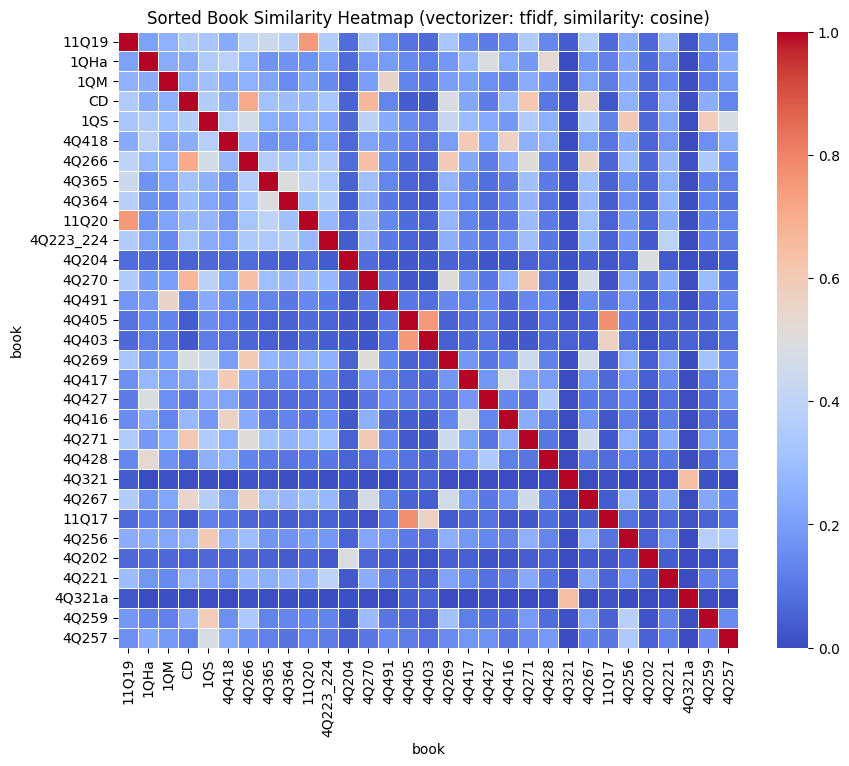

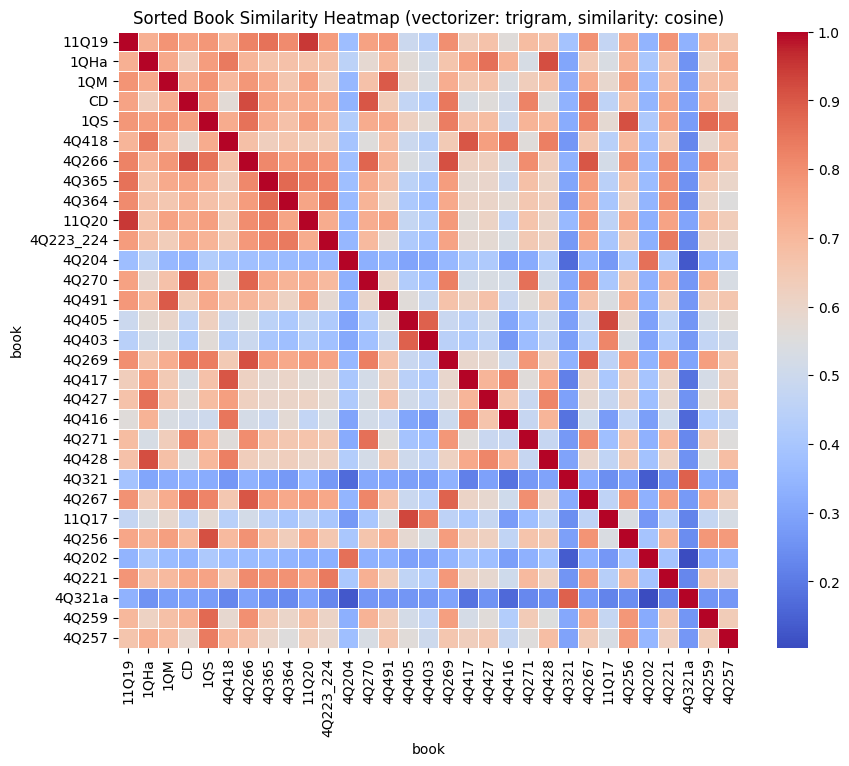

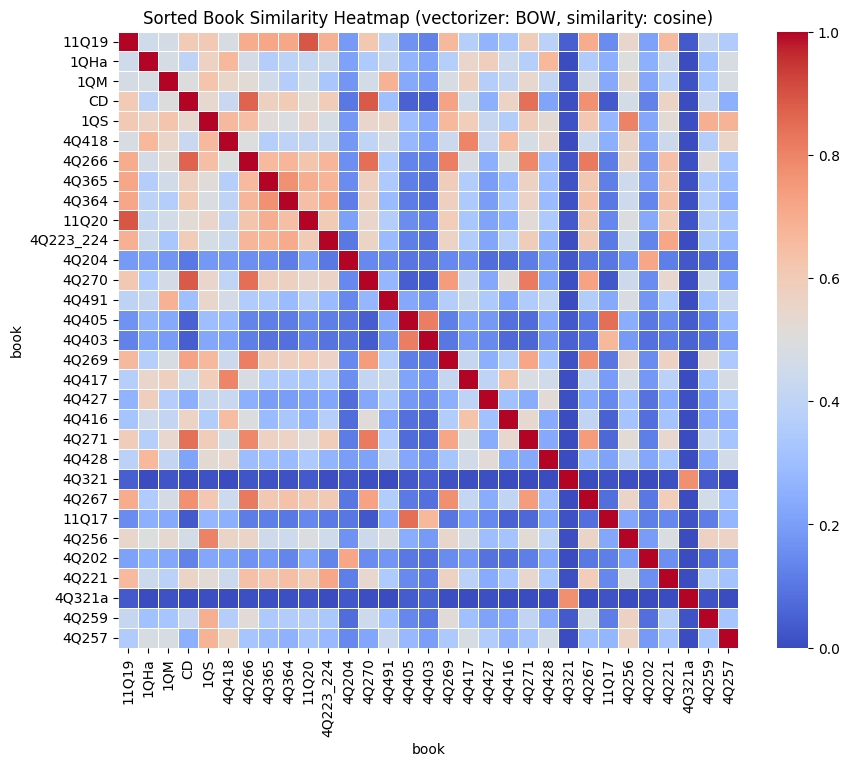

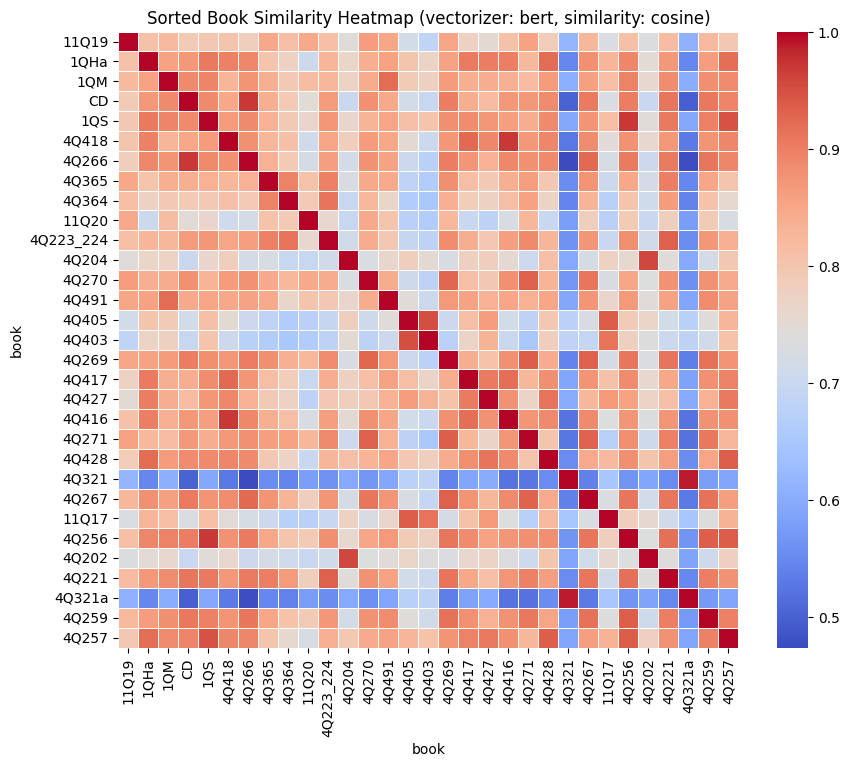

In [7]:


for method in similarity_matrices_all.keys():
    unique_tuples_list = get_best_pairs(similarity_matrices_all, 30, "trigram_cosine")

    s = []
    for p in unique_tuples_list:
        if p[0][0] not in s:
            s.append(p[0][0])
        if p[0][1] not in s:
            s.append(p[0][1])

    sim_matrix = similarity_matrices_all[method]
    sim_matrix = sim_matrix[sim_matrix.index.isin(s)]
    sim_matrix = sim_matrix[sim_matrix.index]
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix, cmap='coolwarm', linewidths=.5, annot=False)
    plt.title(
        'Sorted Book Similarity Heatmap (vectorizer: {}, similarity: {})'.format(method.split("_")[0],
                                                                                 method.split("_")[1]))
    plt.show()



To perform exact matching between each one of the scrolls could be very computationally intensive.
Here’s how I’m dealing with it:

1. **Most Prominent Scrolls**: The previous step, which identifies the most prominent similar scroll pairs.
2. **Sequence Matcher**: Given two potential books, a window size, and a similarity threshold, this step will provide both books with the most similar sentences marked.
   1. **Window Size**: Defines the length of the word sequence the algorithm will check (for `window_size = 1`, it will check word by word).
   2. **Similarity Threshold**: Determines how close the sentences need to be. For `similarity_threshold = 1`, the sentences must be identical.


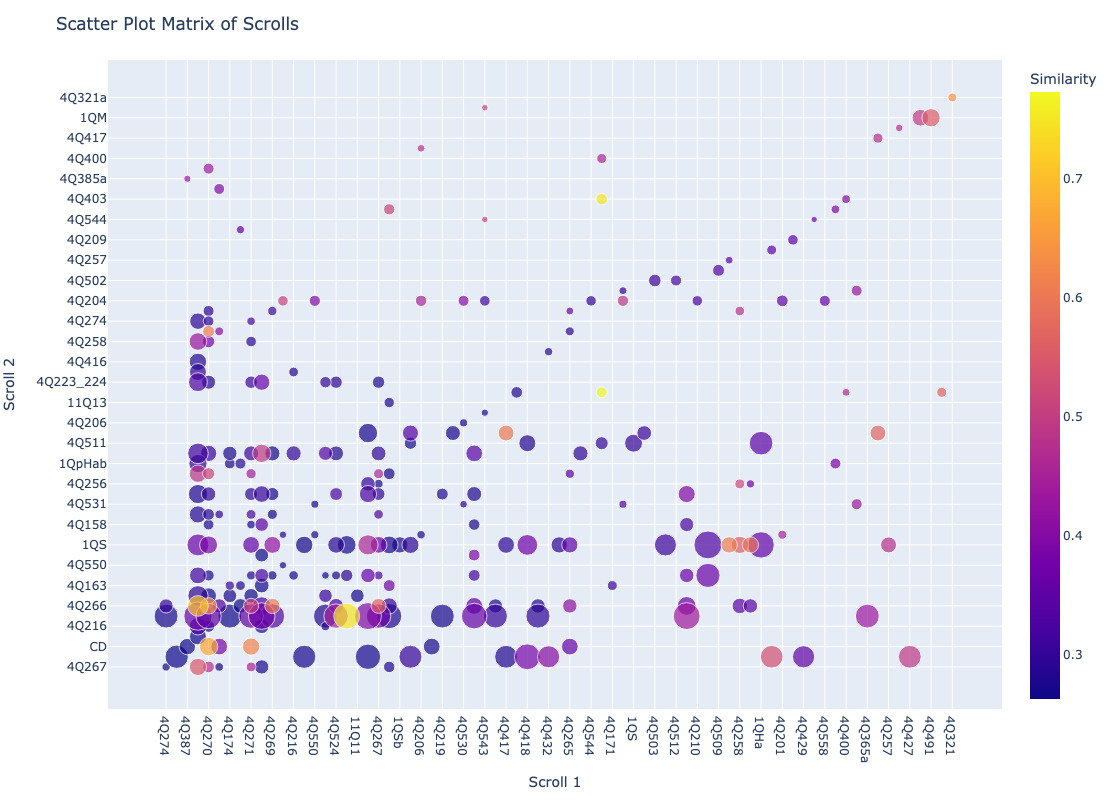

In [8]:
import pandas as pd
import plotly.express as px


def get_top_pairs_by_method(similarity_matrices, method):
    df = similarity_matrices[method]

    stacked_df = df.stack()
    stacked_df = stacked_df.to_frame().rename(columns={0: "sim"})
    stacked_df = stacked_df[stacked_df.index.get_level_values(0) != stacked_df.index.get_level_values(1)].sort_values(
        by="sim", ascending=False)

    return stacked_df


df_by_n_words = get_top_pairs_by_method(similarity_matrices_all, method="tfidf_cosine")
df_by_n_words.index = df_by_n_words.index.set_names(["scroll1", "scroll2"])
df_by_n_words = pd.merge(df_by_n_words.reset_index(),
                         df_by_book.rename(columns={"book": "scroll1"})[["scroll1", "number_of_words"]],
                         on="scroll1").rename(columns={"number_of_words": "number_of_words1"})
df_by_n_words = pd.merge(df_by_n_words.reset_index(),
                         df_by_book.rename(columns={"book": "scroll2"})[["scroll2", "number_of_words"]],
                         on="scroll2").rename(columns={"number_of_words": "number_of_words2"})
df_by_n_words["mean_n_of_words"] = (df_by_n_words["number_of_words1"] + df_by_n_words["number_of_words2"]) / 2
df_by_n_words['sorted_tuple'] = df_by_n_words.apply(lambda x: tuple(sorted([x['scroll1'], x['scroll2']])), axis=1)
df_by_n_words = df_by_n_words.drop_duplicates(subset='sorted_tuple').drop(columns='sorted_tuple')

df_by_n_words = df_by_n_words.sort_values(by="sim", ascending=False)
df_by_n_words = df_by_n_words.iloc[:250, :].sort_values(by="sim")
# df_by_n_words = df_by_n_words[df_by_n_words["sim"] > df_by_n_words["sim"].quantile(0.998)]


fig = px.scatter(df_by_n_words, x="scroll1", y="scroll2", size="mean_n_of_words", color="sim",
                 hover_name="scroll1", hover_data={"scroll2": True, "mean_n_of_words": True, "sim": True},
                 labels={"sim": "Similarity", "scroll1": "Scroll 1", "scroll2": "Scroll 2"})

fig.update_layout(title="Scatter Plot Matrix of Scrolls",
                  xaxis_title="Scroll 1",
                  yaxis_title="Scroll 2",
                  width=1200,  # Set the desired width
                  height=800)  # Set the desired height

fig.show()

In [9]:
from tqdm.notebook import tqdm

nltk.download('punkt')
from difflib import SequenceMatcher


# Function to create windows of a given size
def create_windows(tokens, window_size=10):
    return [tokens[i:i + window_size] for i in range(len(tokens) - window_size + 1)]


def is_similar(window1, window2, threshold=0.99):
    return SequenceMatcher(None, ' '.join(window1), ' '.join(window2)).ratio() > threshold


# Function to merge overlapping or consecutive positions
def merge_positions(positions, window_size=10):
    if not positions:
        return []
    positions = sorted(positions)
    merged = []
    start, end = positions[0], positions[0] + window_size
    for pos in positions[1:]:
        if pos <= end:
            end = max(end, pos + window_size)
        else:
            merged.append((start, end))
            start, end = pos, pos + window_size
    merged.append((start, end))
    return merged


# Function to highlight text segments
def highlight_text(text, merged_positions):
    highlighted_text = text
    offset = 0

    for start, end in merged_positions:
        window = ' '.join(text.split(" ")[start:end])
        highlighted_window = f"<mark>{window}</mark>"

        start_idx = highlighted_text.find(window, offset)
        if start_idx != -1:
            end_idx = start_idx + len(window)
            highlighted_text = highlighted_text[:start_idx] + highlighted_window + highlighted_text[end_idx:]
            offset = start_idx + len(highlighted_window)

    return highlighted_text


# Get positions to highlight in the original texts

def print_similiarity_by_sequence(df_by_book, book1, book2, window_size, similarity_thresh, only_first_chars=None):
    """
    Compare two texts from a dataframe, find similar segments, and highlight them.

    Parameters:
    df_by_book (pd.DataFrame): DataFrame containing the texts to be compared.
    book1 (str): Identifier for the first text.
    book2 (str): Identifier for the second text.
    window_size (int): Size of the window (number of words) to be used for comparison.
    similarity_ratio (float): Threshold for similarity ratio to consider two segments as similar.
    only_first_words (int, optional): Limit the comparison to the first 'only_first_words' words of each text.

    Returns:
    str: Highlighted text of the first book.
    str: Highlighted text of the second book.
    """
    text1 = df_by_book[df_by_book["book"] == book1]["text"].to_list()[0]
    text2 = df_by_book[df_by_book["book"] == book2]["text"].to_list()[0]

    if only_first_chars:
        text1 = text1[:only_first_chars] if only_first_chars < len(text1) else text1
        text2 = text2[:only_first_chars] if only_first_chars < len(text2) else text2
    tokens1 = text1.split(" ")
    tokens2 = text2.split(" ")
    windows1 = create_windows(tokens1, window_size=window_size)
    windows2 = create_windows(tokens2, window_size=window_size)

    similar_windows = []
    for i, window1 in tqdm(enumerate(windows1)):
        for j, window2 in enumerate(windows2):
            if is_similar(window1, window2, similarity_thresh):
                similar_windows.append((i, j, ' '.join(window1), ' '.join(window2)))

    positions1 = [match[0] for match in similar_windows]
    positions2 = [match[1] for match in similar_windows]

    # Merge overlapping or consecutive positions
    merged_positions1 = merge_positions(positions1)
    merged_positions2 = merge_positions(positions2)

    # Highlight the merged segments in the original texts
    highlighted_text1 = highlight_text(text1, merged_positions1)
    highlighted_text2 = highlight_text(text2, merged_positions2)
    if not merged_positions1 and not merged_positions2:
        return f"No common text with {window_size=}, {similarity_threshold=} for the first {only_first_characters}", ""
    return highlighted_text1, highlighted_text2

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yonatanlou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
def get_top_pairs_by_method(similarity_matrices, method):
    df = similarity_matrices[method]

    stacked_df = df.stack()
    stacked_df = stacked_df.to_frame().rename(columns={0: "sim"})
    stacked_df = stacked_df[stacked_df.index.get_level_values(0) != stacked_df.index.get_level_values(1)].sort_values(
        by="sim", ascending=False)
    pairs = stacked_df.to_dict(orient="dict").get("sim")
    pairs = {tuple(frozenset(key)): value for key, value in pairs.items()}
    return pairs


In [18]:


top_n = 40
method = 'trigram_cosine'
unique_tuples_list = get_best_pairs(similarity_matrices_all, top_n, method)
window_size = 5
similarity_threshold = 0.9
only_first_characters = 5000
html_content = [
    '<meta charset="utf-8">',
    '<style>',
    'body { font-family: Arial, sans-serif; margin: 20px; }',
    'h1 { color: #2E4053; }',
    'h2 { color: #2874A6; }',
    'p { line-height: 1.6; }',
    'mark { background-color: #FFFF00; font-weight: bold; }',
    '.settings { background-color: #f4f4f4; padding: 10px; border: 1px solid #ccc; border-radius: 5px; }',
    '.pair-section { margin-top: 20px; }',
    '.pair-header { background-color: #e8e8e8; padding: 10px; border: 1px solid #ccc; border-radius: 5px; }',
    '</style>'
]
html_content.append(
    f"<div class='settings'><h1>Settings</h1><p>method={method}, top {top_n} pairs, window_size={window_size}, similarity_threshold={similarity_threshold}, only_first_characters={only_first_characters}</p></div>"
)

for pair, similarity_score in tqdm(unique_tuples_list):
    book1, book2 = pair
    if book1 == book2:
        continue

    book1_size_n_words = df_by_book[df_by_book["book"] == book1]["number_of_words"].to_list()[0]
    book2_size_n_words = df_by_book[df_by_book["book"] == book2]["number_of_words"].to_list()[0]
    highlighted_text1, highlighted_text2 = print_similiarity_by_sequence(df_by_book, book1, book2,
                                                                         window_size=window_size,
                                                                         similarity_thresh=similarity_threshold,
                                                                         only_first_chars=only_first_characters)
    html_content.append("<div class='pair-section'>")
    if highlighted_text2 == "":
        html_content.append(
            f"<div class='pair-header'><h1>{book1} vs {book2}</h1></div><p>{highlighted_text1}</p>"
        )
        html_content.append("</div>")
        continue

    html_content.append(
        f"<div class='pair-header'><h1>{book1} vs {book2} - similarity_score={similarity_score:.2f}</h1><p>window_size={window_size}, similarity_threshold={similarity_threshold}, only_first_characters={only_first_characters}</p></div>"
    )
    html_content.append(f"<h2>{book1} (word length: {book1_size_n_words}):</h2><p>{highlighted_text1}</p>")
    html_content.append(f"<h2>{book2} (word length: {book2_size_n_words}):</h2><p>{highlighted_text2}</p>")
    html_content.append("</div>")

# Write the HTML content to a file
html_output = "\n".join(html_content)
with open(f"{BASE_DIR}/notebooks/reports/similarity_report_{method=}_{top_n=}.html", "w", encoding="utf-8") as f:
    f.write(html_output)

print(f"HTML file saved as {BASE_DIR}/notebooks/reports/similarity_report_{method=}_{top_n=}.html")


  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

HTML file saved as /Users/yonatanlou/dev/QumranNLP/notebooks/reports/similarity_report_method='trigram_cosine'_top_n=40.html


In [19]:


top_n = 40
method = "all"  #None is averaging all methods
unique_tuples_list = get_best_pairs(similarity_matrices_all, top_n)
window_size = 5
similarity_threshold = 0.9
only_first_characters = 2000
html_content = [
    '<meta charset="utf-8">',
    '<style>',
    'body { font-family: Arial, sans-serif; margin: 20px; }',
    'h1 { color: #2E4053; }',
    'h2 { color: #2874A6; }',
    'p { line-height: 1.6; }',
    'mark { background-color: #FFFF00; font-weight: bold; }',
    '.settings { background-color: #f4f4f4; padding: 10px; border: 1px solid #ccc; border-radius: 5px; }',
    '.pair-section { margin-top: 20px; }',
    '.pair-header { background-color: #e8e8e8; padding: 10px; border: 1px solid #ccc; border-radius: 5px; }',
    '</style>'
]
html_content.append(
    f"<div class='settings'><h1>Settings</h1><p>method={method}, top {top_n} pairs, window_size={window_size}, similarity_threshold={similarity_threshold}, only_first_characters={only_first_characters}</p></div>"
)

for pair, similarity_score in unique_tuples_list:
    book1, book2 = pair
    if book1 == book2:
        continue

    book1_size_n_words = df_by_book[df_by_book["book"] == book1]["number_of_words"].to_list()[0]
    book2_size_n_words = df_by_book[df_by_book["book"] == book2]["number_of_words"].to_list()[0]
    highlighted_text1, highlighted_text2 = print_similiarity_by_sequence(df_by_book, book1, book2,
                                                                         window_size=window_size,
                                                                         similarity_thresh=similarity_threshold,
                                                                         only_first_chars=only_first_characters)
    html_content.append("<div class='pair-section'>")
    if highlighted_text2 == "":
        html_content.append(
            f"<div class='pair-header'><h1>{book1} vs {book2}</h1></div><p>{highlighted_text1}</p>"
        )
        html_content.append("</div>")
        continue

    html_content.append(
        f"<div class='pair-header'><h1>{book1} vs {book2} - similarity_score={similarity_score:.2f}</h1><p>window_size={window_size}, similarity_threshold={similarity_threshold}, only_first_characters={only_first_characters}</p></div>"
    )
    html_content.append(f"<h2>{book1} (word length: {book1_size_n_words}):</h2><p>{highlighted_text1}</p>")
    html_content.append(f"<h2>{book2} (word length: {book2_size_n_words}):</h2><p>{highlighted_text2}</p>")
    html_content.append("</div>")

# Write the HTML content to a file
html_output = "\n".join(html_content)
with open(f"{BASE_DIR}/notebooks/reports/similarity_report_{method=}_{top_n=}.html", "w", encoding="utf-8") as f:
    f.write(html_output)

print(f"HTML file saved as {BASE_DIR}/notebooks/reports/similarity_report_{method=}_{top_n=}.html")


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

HTML file saved as /Users/yonatanlou/dev/QumranNLP/notebooks/reports/similarity_report_method='all'_top_n=40.html
